<a href="https://colab.research.google.com/github/jordantab/BA476/blob/main/BA476_PS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/ColabNotebooks/BA476/housing22.csv')

Mounted at /content/drive


Removed instances where population is at least 20,000 or total_rooms is at least 35,000

In [ ]:
df_new = df[ (df['population'] < 20000) & (df['total_rooms'] < 35000) ]

Baseline amount of missing values in total_bedrooms column

In [ ]:
df['total_bedrooms'].isna().sum()

81

Replace missing values in the total_bedrooms column with the column median

In [ ]:
from sklearn.impute import SimpleImputer
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_imputed = pd.DataFrame(simple_imputer.fit_transform(df))
df_imputed.columns = df.columns


Check to make sure all instances are imputed

In [ ]:
df_imputed['total_bedrooms'].isna().sum()

0

Split the data into train and test. First 5,000 for training and the remainder for testing

In [ ]:
train = df_imputed[:5000]
test = df_imputed[5000:]

Split the data into predictors and outcome

In [ ]:
X_train = train.loc[:, train.columns != 'median_house_value']
X_test = test.loc[:, test.columns != 'median_house_value']
y_train = train['median_house_value']
y_test = test['median_house_value']

Standardize the predictors since we are using Lasso

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std_train = scaler.fit_transform(X_train)
X_std_test = scaler.transform(X_test)

Train Lasso

In [ ]:
from sklearn.linear_model import Lasso

train_predictions = []
test_predictions = []

model_coeffs = []

for num in np.logspace(3,5,100):
  # initialize and train lasso
  lasso = Lasso(alpha=num)
  lasso.fit(X_std_train, y_train)

  # store coefficients of the model
  model_coeffs.append(lasso.coef_)

  # predict on training data
  yhat_train = lasso.predict(X_std_train)
  train_predictions.append(yhat_train)

  # predict on testing data
  yhat_test = lasso.predict(X_std_test)
  test_predictions.append(yhat_test)


Compute MSE

In [ ]:
from sklearn.metrics import mean_squared_error

train_mse = []
test_mse = []

for i in range(len(train_predictions)):
  # calcalate train mse and store them
  mse_train = mean_squared_error(y_train,train_predictions[i])
  train_mse.append(mse_train)

  # calculate test mse and store them
  mse_test = mean_squared_error(y_test, test_predictions[i])
  test_mse.append(mse_test)



Get the MSE and the lambda of the best performing model

In [ ]:
min_test_mse = min(test_mse)
index = test_mse.index(min_test_mse)
lambdas = np.logspace(3,5,100)
best_alpha = lambdas[index]

Plot test and train mse as lambda changes

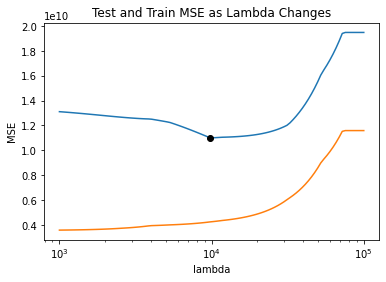

In [ ]:
fig,ax = plt.subplots()
ax.plot(np.logspace(3,5,100),test_mse)
ax.plot(np.logspace(3,5,100),train_mse)
plt.xlabel("lambda")
ax.set_xscale('log')
plt.ylabel("MSE")
plt.title("Test and Train MSE as Lambda Changes")
plt.plot(best_alpha, min_test_mse, marker="o", markeredgecolor="black", markerfacecolor="black")

Plot coefficients as lambda changes

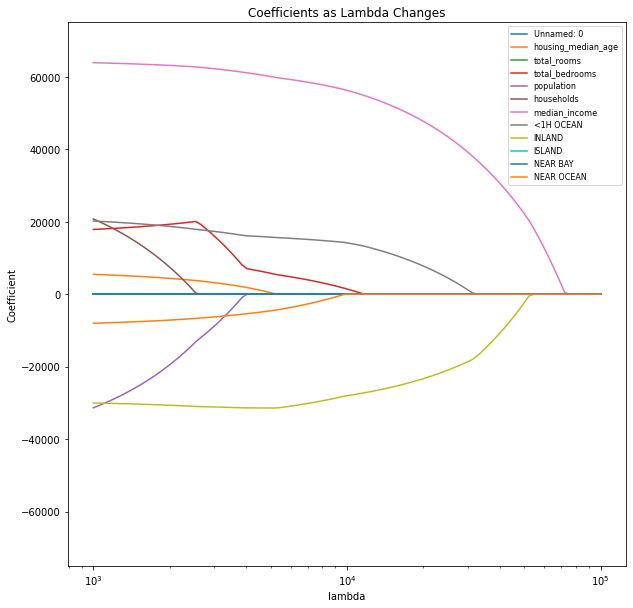

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.logspace(3,5,100),model_coeffs)
plt.xlabel("lambda")
ax.set_xscale('log')
plt.ylim([-75000, 75000])
plt.ylabel("Coefficient")
plt.title("Coefficients as Lambda Changes")
plt.legend(X_train.columns, prop={'size' : 8})

Predictors with non-zero coefficients for the best model

In [ ]:
indices = np.nonzero(model_coeffs[index])

In [ ]:
predictors = []

for i in range(len(indices[0])):
  index = indices[0][i]
  predictors.append(X_train.columns[index])

In [ ]:
predictors

['total_bedrooms', 'median_income', '<1H OCEAN', 'INLAND', 'NEAR OCEAN']